> Import dataset

In [1]:
pip install tsaug

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries

import os
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pickle import dump
from tsaug import AddNoise
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

plt.rc('font', size=16) 

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [3]:
# Set seed for reproducibility

seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
# Load the dataset

x_data = np.load('../input/training-dataset-homework2zip/x_train.npy')
y_data = np.load('../input/training-dataset-homework2zip/y_train.npy')
x_data.shape, y_data.shape

((2429, 36, 6), (2429,))

> Inspect data

In [5]:
labels = ['Wish',         # 0
          'Another',      # 1
          'Comfortably',  # 2
          'Money',        # 3
          'Breathe',      # 4
          'Time',         # 5
          'Brain',        # 6
          'Echoes',       # 7
          'Wearing',      # 8
          'Sorrow',       # 9
          'Hey',          # 10
          'Shine']        # 11

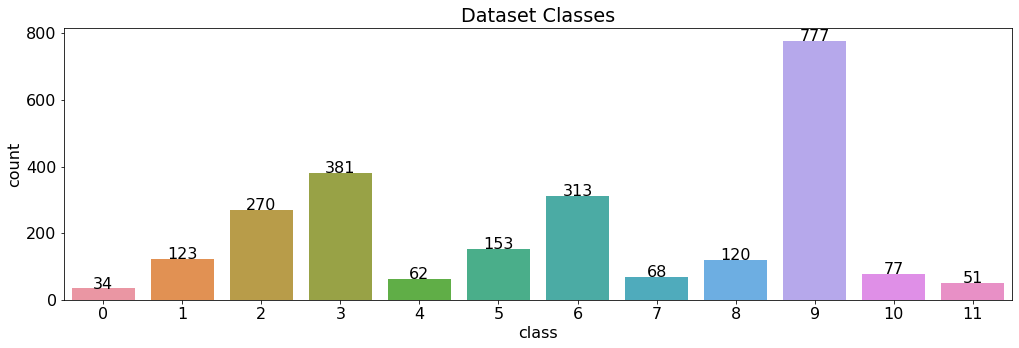

In [6]:
# Inspect classes

df = pd.DataFrame(y_data, columns = ['class'])

plt.figure(figsize=(17,5))
graph = sns.countplot(x = 'class', data = df)

i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        df['class'].value_counts()[i],ha="center")
    i += 1

plt.title('Dataset Classes')
plt.show()


> Preprocessing

In [7]:
# Reshape data

#reshape the data in a format where each feature is a column
num_instances, num_time_steps, num_features = x_data.shape
x_data_flat = np.reshape(x_data, newshape=(-1, num_features))

#create the dataframe
columns = ['col_0','col_1','col_2','col_3','col_4','col_5']
df_data = pd.DataFrame(x_data_flat, columns = columns)
df_data

,col_0,col_1,col_2,col_3,col_4,col_5
0,17.59700,8.17130,-1.78420,-19.70600,-9.71350,-61.8870
1,0.22974,-5.89560,16.83700,5.03900,2.43320,58.9140
2,-29.65400,-21.29600,29.10300,-0.47503,75.39100,10.6650
3,-59.21000,-29.56500,17.97100,-45.60600,19.41200,-43.0140
4,-72.06400,-25.85500,0.46536,-59.15100,-29.10500,-11.9130
...,...,...,...,...,...,...
87439,3.51190,-1.03240,-1.69900,4.15790,2.75430,5.9823
87440,0.70853,-0.94622,-1.91760,2.09480,-4.76750,7.4118
87441,0.20638,1.02870,-0.92512,-0.71633,1.73330,4.7638
87442,4.14290,1.09390,-0.18921,1.14100,0.93441,4.1742


In [8]:
# Reshape labels

y_data_flat = []
for i in range(0, y_data.shape[0]):
    for j in range (i*36,(i+1)*36):
        y_data_flat = np.append(y_data_flat, y_data[i])
y_data_flat = y_data_flat.astype(int)

df_data["class"] = y_data_flat
df_data

,col_0,col_1,col_2,col_3,col_4,col_5,class
0,17.59700,8.17130,-1.78420,-19.70600,-9.71350,-61.8870,0
1,0.22974,-5.89560,16.83700,5.03900,2.43320,58.9140,0
2,-29.65400,-21.29600,29.10300,-0.47503,75.39100,10.6650,0
3,-59.21000,-29.56500,17.97100,-45.60600,19.41200,-43.0140,0
4,-72.06400,-25.85500,0.46536,-59.15100,-29.10500,-11.9130,0
...,...,...,...,...,...,...,...
87439,3.51190,-1.03240,-1.69900,4.15790,2.75430,5.9823,11
87440,0.70853,-0.94622,-1.91760,2.09480,-4.76750,7.4118,11
87441,0.20638,1.02870,-0.92512,-0.71633,1.73330,4.7638,11
87442,4.14290,1.09390,-0.18921,1.14100,0.93441,4.1742,11


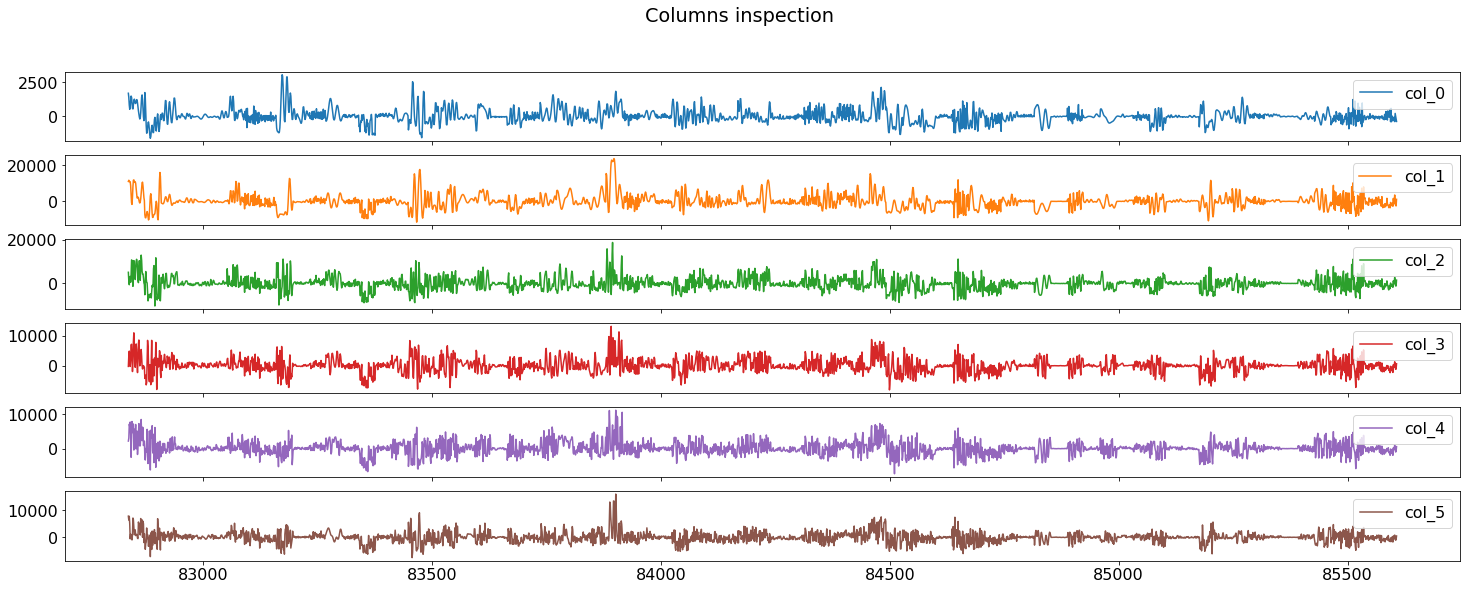

In [9]:
# Show columns' trends

axis = (df_data[df_data['class'] == 10][columns]).plot(subplots=True, figsize=(25, 9), title="Columns inspection")
for ax in axis:
    ax.legend(loc='upper right')

In [10]:
# Show sequence's trend

def inspect_seq(x_seq, idx):
    x_values = np.reshape(x_seq[idx], newshape=(-1, x_seq.shape[2])) #reshape and select the idx-th element 
    x_values = pd.DataFrame(x_values, columns = columns) #convert into dataframe

    axis = x_values.plot(subplots=True, figsize=(17, 9), title="Columns inspection") #plot each column
    for ax in axis:
        ax.legend(loc='upper right')

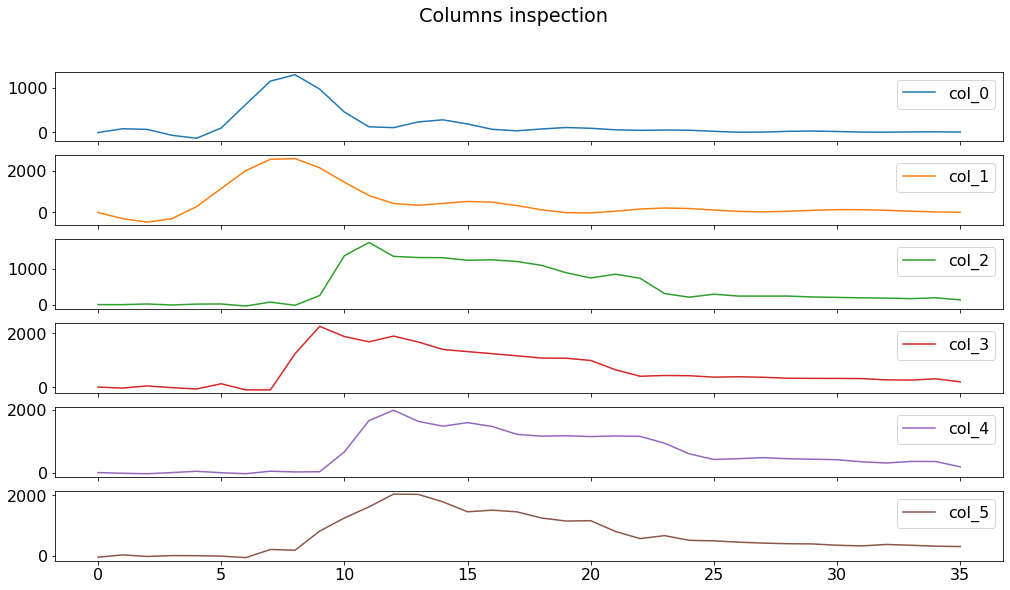

In [11]:
# Inspect n-th sequence

n = 2400
inspect_seq(x_data, n)

In [12]:
# Split into train and test

x_train, x_test, y_train, y_test = train_test_split(x_data,y_data, test_size=0.2, random_state=seed, shuffle=True, stratify=y_data)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1943, 36, 6), (486, 36, 6), (1943,), (486,))

In [13]:
# Standardize dataset values with mean 0 and variance 1

#fit scaler on train set
num_instances, num_time_steps, num_features = x_train.shape
x_data_flat = np.reshape(x_train, newshape=(-1, num_features))

scaler = StandardScaler()
scaler = scaler.fit(x_data_flat)

x_train = np.reshape(x_data_flat, newshape=(num_instances, num_time_steps, num_features))

In [14]:
# Data augmentation

my_augmenter = AddNoise(scale=(0.1, 0.3)) @ 1.0  # with 100% probability, add random noise up to 10% - 30%
x_train_aug = my_augmenter.augment(x_train)

x_train_aug = np.concatenate((x_train,x_train_aug))
y_train_aug = np.concatenate((y_train,y_train))

x_train_aug.shape, y_train_aug.shape

((3886, 36, 6), (3886,))

In [15]:
# Inspect augmented data

#reshape the data in a format where each feature is a column
num_instances, num_time_steps, num_features = x_train.shape
x_train_flat = np.reshape(x_train, newshape=(-1, num_features))

#create the dataframe
df_train = pd.DataFrame(x_train_flat, columns = columns)

y_data_flat = []
for i in range(0, y_train.shape[0]):
    for j in range (i*36,(i+1)*36):
        y_data_flat = np.append(y_data_flat, y_train[i])
y_data_flat = y_data_flat.astype(int)
df_train["class"] = y_data_flat


#reshape the data in a format where each feature is a column
num_instances, num_time_steps, num_features = x_train_aug.shape
x_train_aug_flat = np.reshape(x_train_aug, newshape=(-1, num_features))

#create the dataframe
df_train_aug = pd.DataFrame(x_train_aug_flat, columns = columns)

y_data_flat = []
for i in range(0, y_train_aug.shape[0]):
    for j in range (i*36,(i+1)*36):
        y_data_flat = np.append(y_data_flat, y_train_aug[i])
y_data_flat = y_data_flat.astype(int)
df_train_aug["class"] = y_data_flat

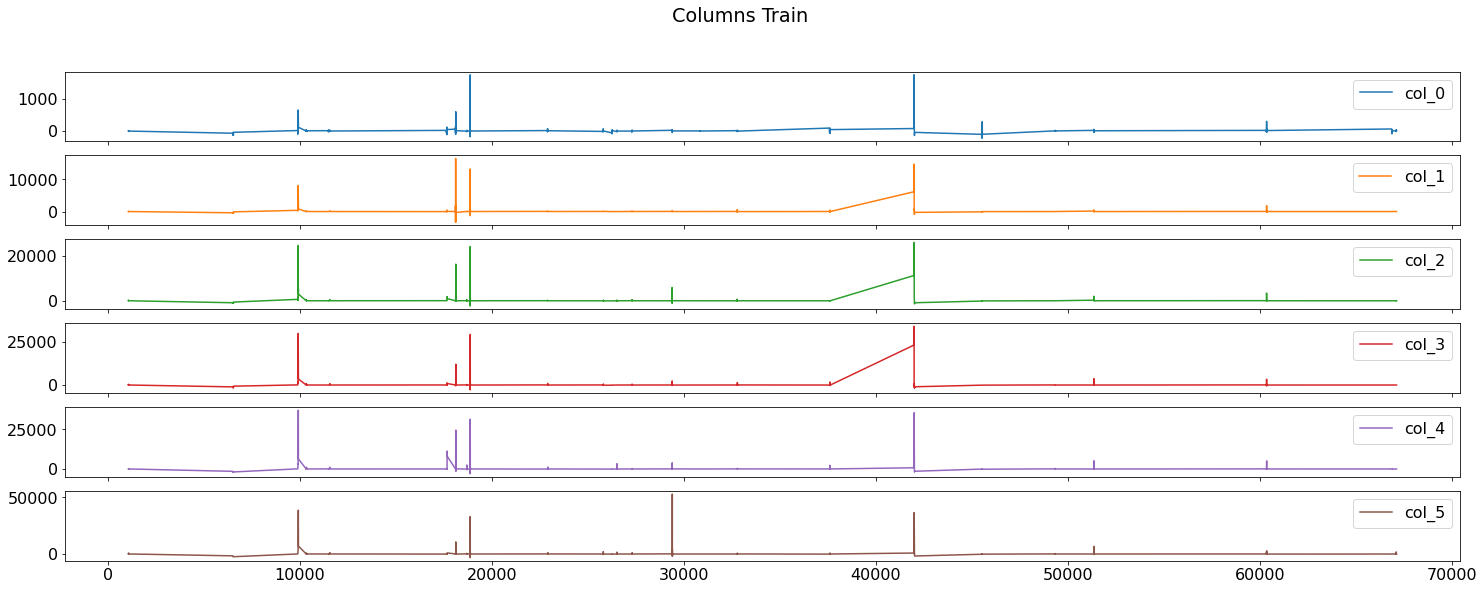

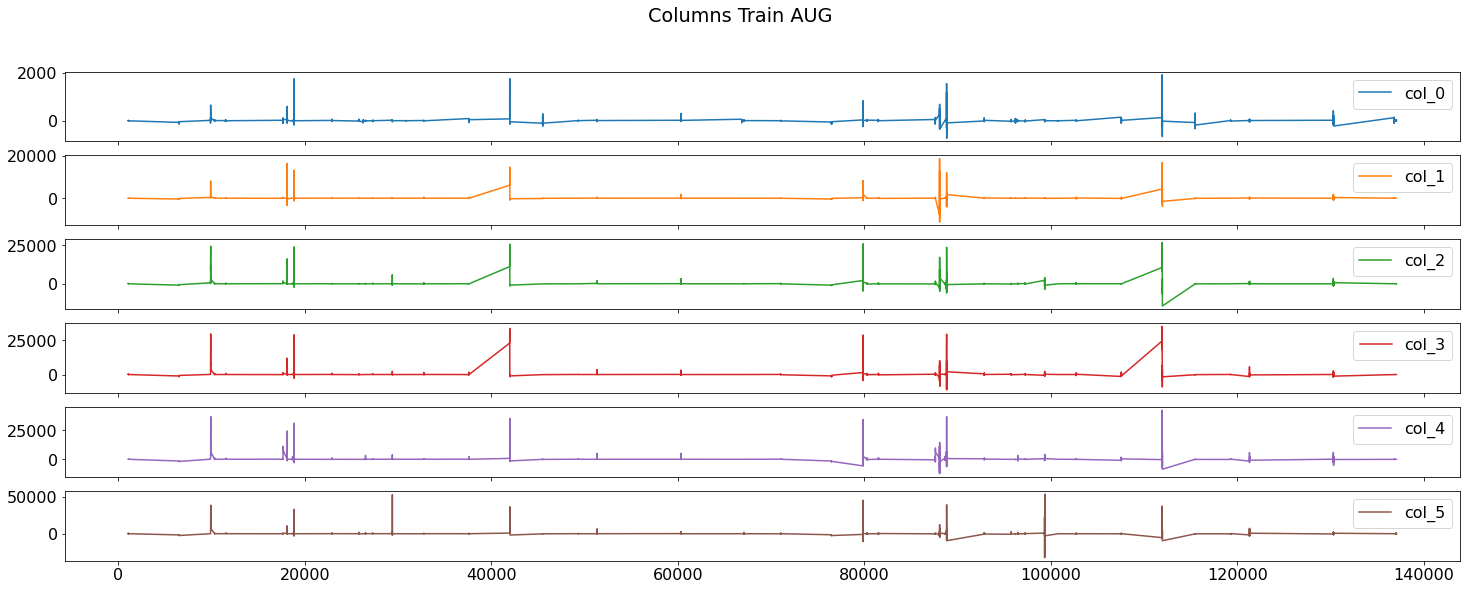

In [16]:
# Plot augmented data and compare with the original sample

axis1 = (df_train[df_train['class'] == 0][columns]).plot(subplots=True, figsize=(25, 9), title="Columns Train")
for ax in axis1:
    ax.legend(loc='upper right')
axis2 = (df_train_aug[df_train_aug['class'] == 0][columns]).plot(subplots=True, figsize=(25, 9), title="Columns Train AUG")
for ax in axis2:
    ax.legend(loc='upper right')

In [17]:
# Standardize dataset values with mean 0 and variance 1

#transform train set
num_instances, num_time_steps, num_features = x_train_aug.shape
x_data_flat = np.reshape(x_train_aug, newshape=(-1, num_features))

x_data_flat = scaler.transform(x_data_flat)

x_train_aug = np.reshape(x_data_flat, newshape=(num_instances, num_time_steps, num_features))


#transform test set
num_instances, num_time_steps, num_features = x_test.shape
x_data_flat = np.reshape(x_test, newshape=(-1, num_features))

x_data_flat = scaler.transform(x_data_flat)

x_test = np.reshape(x_data_flat, newshape=(num_instances, num_time_steps, num_features))

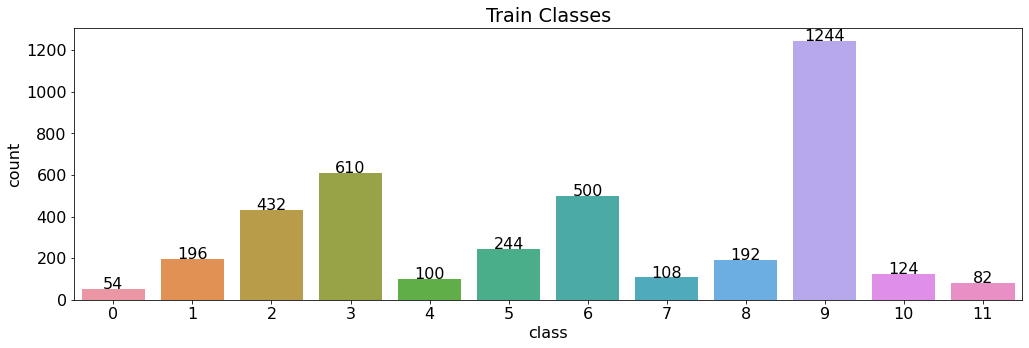

In [18]:
# Inspect train split

df = pd.DataFrame(y_train_aug, columns = ['class'])

plt.figure(figsize=(17,5))
graph = sns.countplot(x = 'class', data = df)

i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        df['class'].value_counts()[i],ha="center")
    i += 1

plt.title('Train Classes')
plt.show()

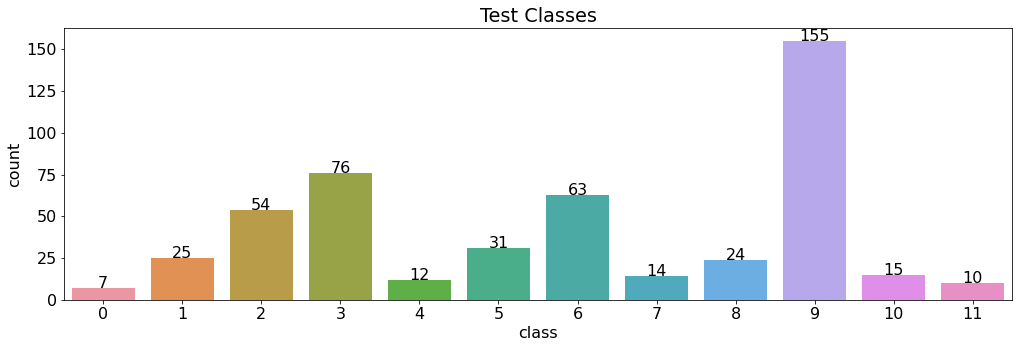

In [19]:
# Inspect test split

df = pd.DataFrame(y_test, columns = ['class'])

plt.figure(figsize=(17,5))
graph = sns.countplot(x = 'class', data = df)

i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        df['class'].value_counts()[i],ha="center")
    i += 1

plt.title('Test Classes')
plt.show()

In [20]:
# Convert labels in one-hot-encoding

print(y_train_aug[0])
y_train_aug = tfk.utils.to_categorical(y_train_aug)
y_test = tfk.utils.to_categorical(y_test)
print(y_train_aug[0])

3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


> Build and train the model

In [21]:
# Define parameter of the model

input_shape = x_train_aug.shape[1:]
classes = y_train_aug.shape[-1]
batch_size = 64
epochs = 400

In [22]:
# Define the model

def build_1DCNN_classifier(input_shape, classes):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(512,7,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.35, seed = seed)(cnn)
    cnn = tfkl.Conv1D(512,5,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.35, seed = seed)(cnn)
    cnn = tfkl.Conv1D(256,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.35, seed = seed)(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.35, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

2022-12-19 14:52:07.138111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 14:52:07.273793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 14:52:07.274574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 14:52:07.276273: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 512)           15872     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 512)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 512)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 256)           655616    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 256)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 256)            0     

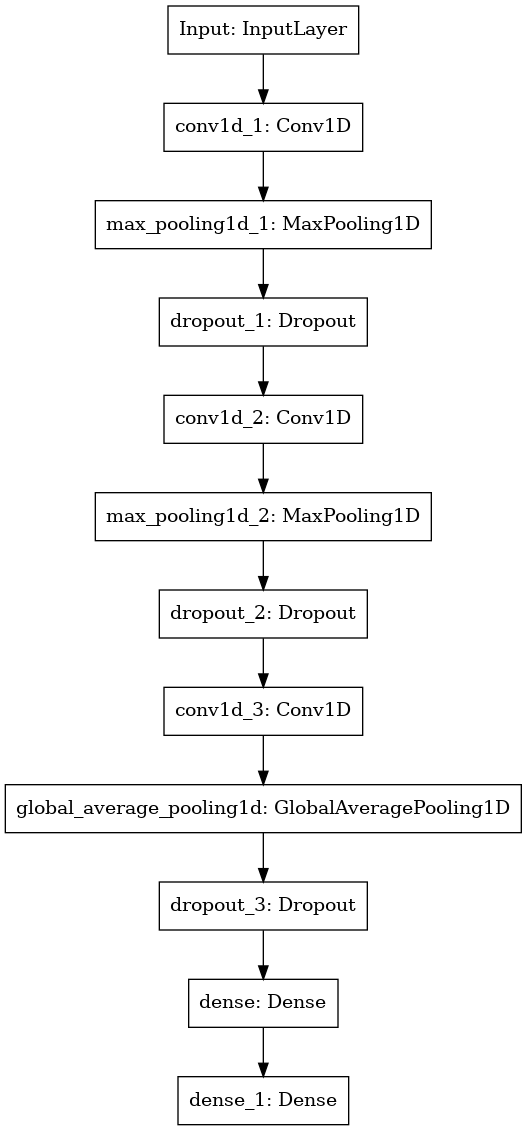

In [23]:
# Build the model

model = build_1DCNN_classifier(input_shape, classes)
model.summary()
tfk.utils.plot_model(model)

In [646]:
# Train the model

history = model.fit(
    x = x_train_aug,
    y = y_train_aug,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_test, y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.85, min_lr=1e-5)
    ]
).history

Epoch 1/400
61/61 [==============================] - 1s 13ms/step - loss: 2.1080 - accuracy: 0.3304 - val_loss: 1.9094 - val_accuracy: 0.3621
Epoch 2/400
61/61 [==============================] - 0s 6ms/step - loss: 1.8868 - accuracy: 0.3770 - val_loss: 1.7853 - val_accuracy: 0.3909
Epoch 3/400
61/61 [==============================] - 0s 6ms/step - loss: 1.7938 - accuracy: 0.3973 - val_loss: 1.6636 - val_accuracy: 0.4239
Epoch 4/400
61/61 [==============================] - 0s 6ms/step - loss: 1.6506 - accuracy: 0.4452 - val_loss: 1.5403 - val_accuracy: 0.4856
Epoch 5/400
61/61 [==============================] - 0s 6ms/step - loss: 1.5344 - accuracy: 0.4902 - val_loss: 1.4004 - val_accuracy: 0.5000
Epoch 6/400
61/61 [==============================] - 0s 6ms/step - loss: 1.4082 - accuracy: 0.5149 - val_loss: 1.3200 - val_accuracy: 0.5329
Epoch 7/400
61/61 [==============================] - 0s 6ms/step - loss: 1.3445 - accuracy: 0.5404 - val_loss: 1.2848 - val_accuracy: 0.5782
Epoch 8/400


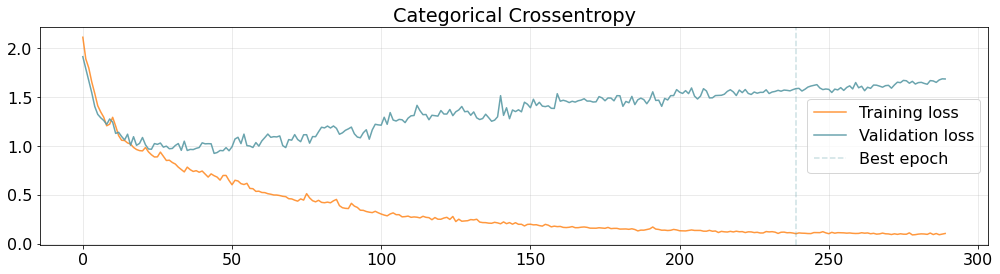

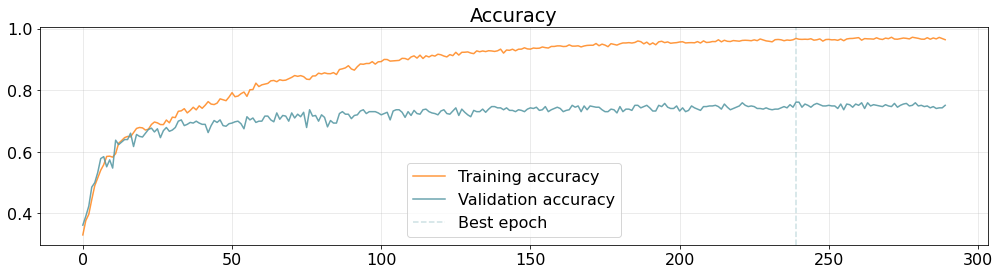

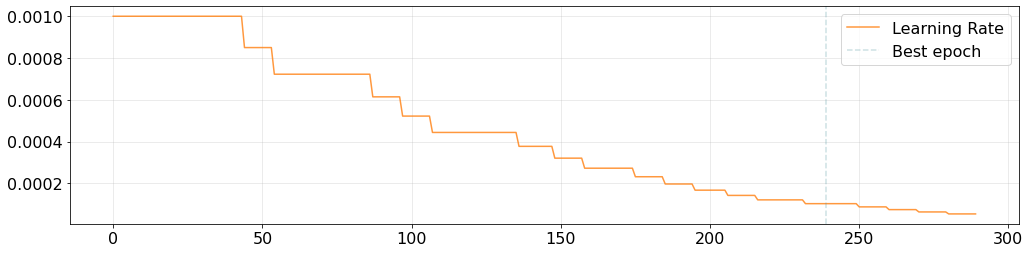

In [647]:
# Plot results

best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [648]:
# Predict the test set

predictions = model.predict(x_test)
predictions.shape

(486, 12)

Accuracy: 0.7613
Precision: 0.7679
Recall: 0.6818
F1: 0.7103


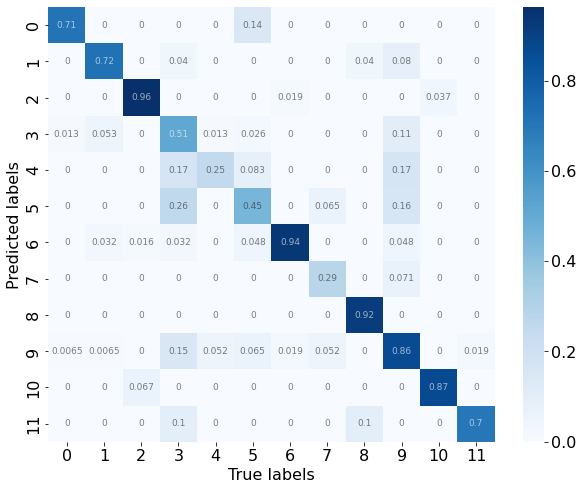

In [649]:
# Compute the confusion matrix

cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

cm = cm /cm.astype(float).sum(axis=1);

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', annot=True, annot_kws={'fontsize':9,'alpha':0.6})#, xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [650]:
# Save the model

model.save('SubmissionModel')
shutil.make_archive("SubmissionModel", 'zip', "./SubmissionModel")

'/kaggle/working/SubmissionModel.zip'

In [651]:
# Save the scaler

dump(scaler, open('scaler.pkl', 'wb'))